In [2]:
# %load_ext autoreload
# %autoreload 2
import sys, os
import torch

In [3]:
import glob, os
import mediapy as media
import torch
from torch.utils.data import DataLoader

from load_model_from_ckpt import load_model, get_sampler, init_samples
from datasets import get_dataset, data_transform, inverse_data_transform
from runners.ncsn_runner import conditioning_fn

from os.path import expanduser
home = expanduser("~")

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')

# Set directories to download model, data

In [4]:
# Set These
GDRIVE_URL = "https://drive.google.com/drive/folders/1bM6wqU_kymoljz5uYQRCYNup_8adBfLH" # smmnist_big_5c5_unetm_b2
path = 'D:\Implementation\VD'
EXP_PATH = os.path.join(path, "scratch\MCVD_SMMNIST_pred")
DATA_PATH = os.path.join(home, "scratch\Datasets\MNIST")

# Download experiment (model checkpoint, config, etc.)

In [4]:
GDRIVE_URL = GDRIVE_URL.replace("?usp=sharing", "")
!gdown --fuzzy {GDRIVE_URL} -O {EXP_PATH}/ --folder

Retrieving folder 1CzwozDKbsOH_V2099N9-HBeeMO4441iT logs
Processing file 14Di0OplaG_F-Ogmmv8w_K0NqYP5Bag9r args.yml
Processing file 1uTfMtTfTT5WMAdDR1x2WNrOQnldk__yA checkpoint_140000.pt
Processing file 1xOY4-oh7jSCSKqtDktvtTCt3CasNzT64 config.yml
Processing file 1zuqnoOOxfvBzjpgaFR77j8OGUUs808oj epochs.png
Processing file 1PMXh9CluffmccQO_llGmRMf6DRhXU9Db fvd_log.png
Processing file 1BWgT0O20aaa-TtsKezIB1UxMzNkL0HOH fvd.png
Processing file 1DWk2o8zyj4h9lfaZcLbUxln4ZiV7z04v grad_log.png
Processing file 10iH96rRLPlHPRaZHuS7SNdYg0KjOlah6 grad.png
Processing file 1Eebka2ybBXoYXBGOdom1059LEl2wyC-f loss_log.png
Processing file 1SmtLNaMHHUV4L6SXGV_QacQ7augGQBC3 loss.png
Processing file 1hQo6pWh3pIHteyVx90_YzsDg9Z-BKSHm lpips_log.png
Processing file 1I2sme46c9twlixOYkThZxcIh8ptpzBZz lpips.png
Processing file 1B_LvuvnNmmNKqacX2NLx4_-_0o6dniuZ lr.png
Processing file 1v6i8iwed7QDw84LKpsl9jpoAQZ-UZ410 meters.pkl
Processing file 1cmaGJZ3El7xe91JvJkt4QpA00HYwnATA mse_log.png
Processing file 1Pgl_r0

Retrieving folder list
Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=14Di0OplaG_F-Ogmmv8w_K0NqYP5Bag9r
To: D:\Implementation\VD\scratch\MCVD_SMMNIST_pred\logs\args.yml

  0%|          | 0.00/1.09k [00:00<?, ?B/s]
100%|##########| 1.09k/1.09k [00:00<?, ?B/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1uTfMtTfTT5WMAdDR1x2WNrOQnldk__yA
From (redirected): https://drive.google.com/uc?id=1uTfMtTfTT5WMAdDR1x2WNrOQnldk__yA&confirm=t&uuid=0deb4271-37a3-42ed-b5f2-109e969462f5
To: D:\Implementation\VD\scratch\MCVD_SMMNIST_pred\logs\checkpoint_140000.pt

  0%|          | 0.00/864M [00:00<?, ?B/s]
  0%|          | 1.05M/864M [00:00<02:13, 6.48MB/s]
  0%|          | 2.62M/864M [00:00<01:34, 9.07MB/s]
  0%|          | 4.19M/864M [00:00<01:32, 9.31MB/s]
  1%|          | 5.24M/864M [00:00<01:39, 8.67MB/s]
  1%|          | 7.34M/864M [00:00<01:25, 10.0MB/s]
  1%|          | 8.39M/864M [00:01<02:47, 5.11MB/s]
  1%|1  

# Load model checkpoint

In [6]:
ckpt_path = glob.glob(os.path.join(EXP_PATH, "logs/checkpoint_*.pt"))[0]
scorenet, config = load_model(ckpt_path, device)
sampler = get_sampler(config)

In [7]:
print(device)
print(ckpt_path)
print(config)

cuda
D:\Implementation\VD\scratch\MCVD_SMMNIST_pred\logs\checkpoint_140000.pt
Namespace(data=Namespace(channels=1, dataset='StochasticMovingMNIST', gaussian_dequantization=False, image_size=64, logit_transform=False, num_digits=2, num_frames=5, num_frames_cond=5, num_workers=0, prob_mask_cond=0.0, random_flip=True, rescaled=True, step_length=0.1, uniform_dequantization=False), device=device(type='cuda'), fast_fid=Namespace(batch_size=1000, begin_ckpt=5000, end_ckpt=300000, ensemble=False, freq=5000, n_steps_each=0, num_samples=1000, pr_nn_k=3, step_lr=0.0, verbose=False), model=Namespace(arch='unetmore', attn_resolutions=[8, 16, 32], ch_mult=[1, 2, 3, 4], cond_emb=False, conditional=True, depth='deep', dropout=0.1, ema=True, ema_rate=0.999, gamma=False, gff=False, n_head_channels=64, ngf=64, noise_in_cond=False, nonlinearity='swish', normalization='InstanceNorm++', num_classes=1000, num_res_blocks=2, output_all_frames=False, sigma_begin=0.02, sigma_dist='linear', sigma_end=0.0001, spad

# Load data

In [8]:
dataset, test_dataset = get_dataset(DATA_PATH, config, video_frames_pred=config.data.num_frames)

Dataset length: 60000
Dataset length: 256


In [16]:
config.data

Namespace(channels=1, dataset='StochasticMovingMNIST', gaussian_dequantization=False, image_size=64, logit_transform=False, num_digits=2, num_frames=5, num_frames_cond=5, num_workers=0, prob_mask_cond=0.0, random_flip=True, rescaled=True, step_length=0.1, uniform_dequantization=False)

In [10]:
len(dataset[0])

2

In [13]:
dataset[0][0].shape, dataset[0][1].shape

(torch.Size([10, 1, 64, 64]), torch.Size([10, 1, 64, 64]))

In [7]:
dataloader = DataLoader(dataset, batch_size=config.training.batch_size, shuffle=True,
                        num_workers=config.data.num_workers)
train_iter = iter(dataloader)
x, y = next(train_iter)

test_loader = DataLoader(test_dataset, batch_size=config.training.batch_size, shuffle=False,
                         num_workers=config.data.num_workers, drop_last=True)
test_iter = iter(test_loader)
test_x, test_y = next(test_iter)
print(test_x.shape)

torch.Size([64, 10, 1, 64, 64])


In [1]:
config

Available objects for config:
    AliasManager
    DisplayFormatter
    HistoryManager
    IPCompleter
    IPKernelApp
    LoggingMagics
    MagicsManager
    OSMagics
    PrefilterManager
    ScriptMagics
    StoreMagics
    ZMQInteractiveShell


In [8]:
test_x = data_transform(config, test_x)
real, cond, cond_mask = conditioning_fn(config, test_x, num_frames_pred=config.data.num_frames,
                                        prob_mask_cond=getattr(config.data, 'prob_mask_cond', 0.0),
                                        prob_mask_future=getattr(config.data, 'prob_mask_future', 0.0))
print(real.shape, cond.shape)

torch.Size([64, 5, 64, 64]) torch.Size([64, 5, 64, 64])


,,,,,,,,,

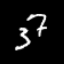
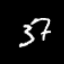
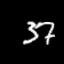
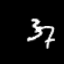
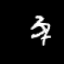
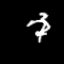
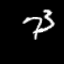
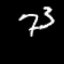
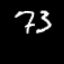
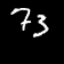

In [9]:
i = 1
# media.show_images(torch.cat([cond[i].permute(0, 2, 3, 1), real[i].permute(0, 2, 3, 1)]))
media.show_images(torch.cat([cond[i], real[i]]))

# Load initial samples

In [10]:
init = init_samples(len(real), config)

torch.Size([64, 5, 64, 64])


,,,,

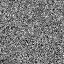
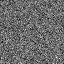
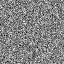
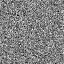
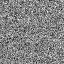

In [11]:
print(init.shape)
media.show_images(init[i])

# Predict
1. Dependency building is somewhat off -- we need to fix it but how?

In [13]:
B = 5
C = 1
N = 5
CN = C*N
H,W = 64, 64
x_mod = torch.ones(B,CN,H,W) # Noisy frames prediction
labels = torch.arange(B) / 10 # Time 
cond = torch.zeros(B,CN,H,W) # conditional frames
x_mod, labels, cond = x_mod.cuda(), labels.cuda(), cond.cuda()
# scorenet(x_mod, labels, cond=cond) # Same error here
unet = scorenet.module.unet
unet(x_mod, labels, cond=cond)

# scorenet.unet

tensor([[[[0.4323, 0.4861, 0.4755,  ..., 0.4502, 0.4179, 0.5837],
          [0.4614, 0.4423, 0.4272,  ..., 0.4117, 0.3835, 0.4778],
          [0.4505, 0.4289, 0.4276,  ..., 0.4028, 0.3582, 0.4740],
          ...,
          [0.4569, 0.4297, 0.4288,  ..., 0.4218, 0.3388, 0.4577],
          [0.4685, 0.4202, 0.4092,  ..., 0.3801, 0.2753, 0.4476],
          [0.3654, 0.3486, 0.3156,  ..., 0.2863, 0.2000, 0.2671]],

         [[0.7035, 0.6789, 0.6155,  ..., 0.5496, 0.6032, 0.6147],
          [0.7152, 0.7176, 0.6038,  ..., 0.5161, 0.6121, 0.6032],
          [0.6682, 0.5867, 0.4882,  ..., 0.4286, 0.5359, 0.5860],
          ...,
          [0.6894, 0.5952, 0.5150,  ..., 0.4832, 0.5677, 0.5976],
          [0.7298, 0.6731, 0.6017,  ..., 0.5309, 0.4472, 0.5797],
          [0.8735, 0.8214, 0.7974,  ..., 0.7518, 0.7100, 0.7761]],

         [[0.4236, 0.3671, 0.3446,  ..., 0.3635, 0.3829, 0.4664],
          [0.3710, 0.3855, 0.3743,  ..., 0.3707, 0.3480, 0.4344],
          [0.3586, 0.3499, 0.3462,  ..., 0

In [23]:
# Get some Walkthrough video and process a video prediction training pipeline here for a change


In [22]:
# This calls on the DDPM sampler and that is it -- it did not train on the models at all
pred = sampler(init, scorenet, cond=cond, cond_mask=cond_mask, subsample=100, verbose=True)

DDPM: 1/100, grad_norm: 143.17007446289062, image_norm: 129.36154174804688, grad_mean_norm: 322.408203125
DDPM: 10/100, grad_norm: 143.18582153320312, image_norm: 130.49656677246094, grad_mean_norm: 322.69921875
DDPM: 20/100, grad_norm: 143.2070770263672, image_norm: 131.72247314453125, grad_mean_norm: 312.307373046875
DDPM: 30/100, grad_norm: 143.56375122070312, image_norm: 133.09909057617188, grad_mean_norm: 319.5882263183594
DDPM: 40/100, grad_norm: 144.76834106445312, image_norm: 134.27481079101562, grad_mean_norm: 322.39599609375
DDPM: 50/100, grad_norm: 148.4901580810547, image_norm: 135.43556213378906, grad_mean_norm: 319.8322448730469
DDPM: 60/100, grad_norm: 157.949462890625, image_norm: 136.23907470703125, grad_mean_norm: 315.7876892089844
DDPM: 70/100, grad_norm: 180.53741455078125, image_norm: 136.8212890625, grad_mean_norm: 314.06097412109375
DDPM: 80/100, grad_norm: 235.56845092773438, image_norm: 137.09437561035156, grad_mean_norm: 319.27471923828125
DDPM: 90/100, grad_n

torch.Size([64, 5, 64, 64])


,,,,,,,,,

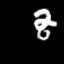
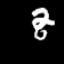
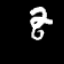
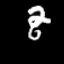
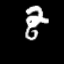
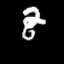
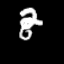
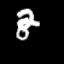
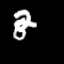
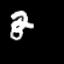

,,,,,,,,,

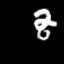
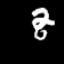
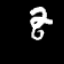
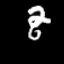
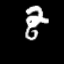
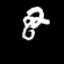
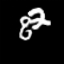
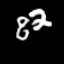
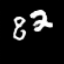
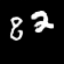

In [13]:
print(pred.shape)
i = 9
media.show_images(torch.cat([cond[i], real[i]]))
media.show_images(torch.cat([cond[i], pred[i]]))

,,,,,,,,,

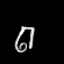
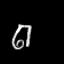
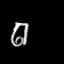
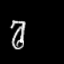
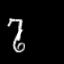
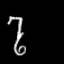
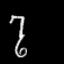
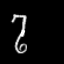
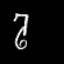
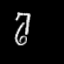

,,,,,,,,,

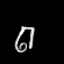
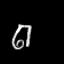
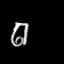
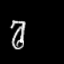
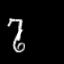
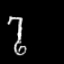
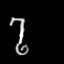
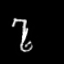
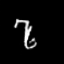
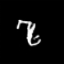

In [14]:
i = 33
media.show_images(torch.cat([cond[i], real[i]]))
media.show_images(torch.cat([cond[i], pred[i]]))